In [132]:
# TensorFlow and tf.keras
import glob
import os
import pathlib
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tqdm import tqdm


In [99]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

model = ResNet50(weights="imagenet")

strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


In [108]:
# Function to decode our images
def decode_image(image_data, output_size=None):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, output_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function to read our test image and return image
def read_image(image, output_size=None):
    image = tf.io.read_file(image)
    image = decode_image(image, output_size)
    return image

In [119]:
def load_dataset(
    base_folder, output_size: Optional[Tuple[int]] = None, nb_images: Optional[int] = None
):

    images_paths = glob.glob(os.path.join(base_folder, "*/*/*/*.jpg"))
    images_ids = [os.path.splitext(os.path.basename(image))[0] for image in images_paths][
        :nb_images
    ]

    print(len(images_paths))

    dataset = tf.data.Dataset.from_tensor_slices((images_paths[:nb_images]))
    dataset = dataset.map(
        lambda img_path: read_image(img_path, output_size), num_parallel_calls=AUTO
    )
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)

    return images_ids, dataset


In [133]:
def encode_dataset(
    images_folder, target_filename, model, output_size=None, nb_images=None, preprocess_input=None
):
    print("Loading images")
    images_ids, dataset = load_dataset(images_folder, output_size=output_size, nb_images=nb_images)

    print("Preprocessing images")
    if preprocess_input is not None:
        dataset.map(preprocess_input, num_parallel_calls=AUTO)

    print("Computing embeddings")
    features = model.predict(dataset)

    features = normalize(features)

    print("Saving embeddings")
    np.save(target_filename, features)

    print("Saving_ids")
    with open(os.path.splitext(target_filename)[0] + "_ids.txt", "w") as f:
        f.write("\n".join(images_ids))


In [131]:
encode_dataset(
    "../index",
    "./data/index_features.npy",
    model,
    preprocess_input=preprocess_input,
    output_size=(224, 224),
    nb_images=2000,
)

Loading images
Preprocessing images
Computing embeddings
Saving embeddings
Saving_ids


In [134]:
encode_dataset(
    "../test",
    "./data/test_features.npy",
    model,
    preprocess_input=preprocess_input,
    output_size=(224, 224),
    nb_images=300,
)


Loading images
Preprocessing images
Computing embeddings
Saving embeddings
Saving_ids


In [124]:
def find_best_neighbors(index_ids, query_ids, index_embeddings, query_embeddings):

    similarities = cosine_similarity(query_embeddings, index_embeddings)

    results = {"id": [], "images": []}

    for i, query_id in enumerate(query_ids):
        results["id"].append(query_id)
        results["images"].append(" ".join(index_ids[np.argsort(similarities[i])[-100:][::-1]]))

    return results


In [152]:
with open("./data/index_features_ids.txt", "r") as f:
    index_ids = np.asarray(f.read().split("\n"))
with open("./data/test_features_ids.txt", "r") as f:
    query_ids = np.asarray(f.read().split("\n"))

index_embeddings = np.load("./data/index_features.npy")
query_embeddings = np.load("./data/test_features.npy")

results = find_best_neighbors(index_ids, query_ids, index_embeddings, query_embeddings)


In [76]:
def get_path(folder, image_id):
    return os.path.join(folder, f"{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg")

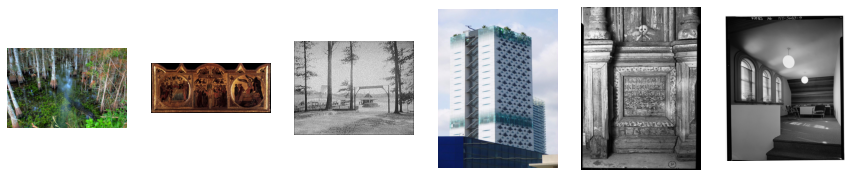

In [154]:
sample = 50

fig, axs = plt.subplots(1, 6, figsize=(15, 8))

img = image.load_img(get_path("../test", results["id"][sample]))
axs[0].imshow(img)
axs[0].set_axis_off()


images_ids = results["images"][sample].split(" ")
for i in range(5):
    img = image.load_img(get_path("../index", images_ids[i]))
    axs[i+1].imshow(img)
    axs[i+1].set_axis_off()


plt.show()


In [ ]:
pd.DataFrame.from_dict(results).to_csv("submission.csv", index=False)